In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import files
import zipfile
import os

In [3]:
with zipfile.ZipFile("dataset_aug.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extracts into "dataset/" directory


In [4]:
from sklearn.model_selection import train_test_split
import shutil

In [5]:
def split_dataset(src_dir, dest_root, train_ratio=0.7, val_ratio=0.15):
    os.makedirs(dest_root, exist_ok=True)
    for split in ['train', 'val', 'test']:
        for digit in range(10):
            os.makedirs(os.path.join(dest_root, split, str(digit)), exist_ok=True)

    for digit in os.listdir(src_dir):
        digit_path = os.path.join(src_dir, digit)
        if not os.path.isdir(digit_path): continue

        images = os.listdir(digit_path)
        train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img_name in train_imgs:
            shutil.copy(os.path.join(digit_path, img_name), os.path.join(dest_root, 'train', digit, img_name))
        for img_name in val_imgs:
            shutil.copy(os.path.join(digit_path, img_name), os.path.join(dest_root, 'val', digit, img_name))
        for img_name in test_imgs:
            shutil.copy(os.path.join(digit_path, img_name), os.path.join(dest_root, 'test', digit, img_name))



In [7]:
# Run this once
split_dataset("dataset/dataset_aug", "dataset_split")

In [44]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((50, 50)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_dir = "dataset_split"

train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=test_transform)
test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


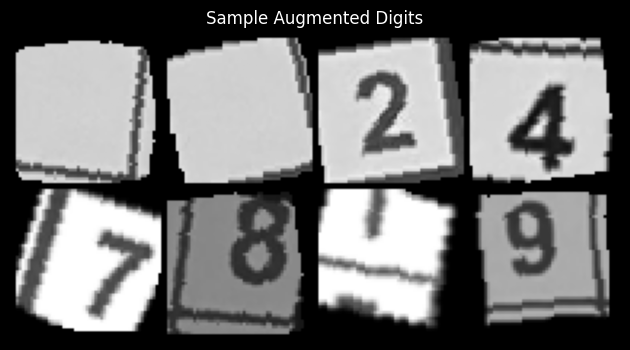

In [45]:
import matplotlib.pyplot as plt
import torchvision

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images[:8], nrow=4, normalize=True)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))  # Convert CHW to HWC
plt.axis('off')
plt.title("Sample Augmented Digits")
plt.show()


In [57]:
import torch.nn as nn

class SmallDigitCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128*6*6, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [58]:
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallDigitCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


def evaluate(model, dataloader, return_preds=False):
    model.eval()
    correct, total = 0, 0
    running_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)

            # Calculate loss
            loss = criterion(preds, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collect predictions if needed
            if return_preds:
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    if return_preds:
        # Calculate precision, recall, and F1-score
        #report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)], digits=4)
        #print(report)

        return avg_loss, accuracy, all_labels, all_preds
    else:
        return avg_loss, accuracy


def train(model, train_loader, val_loader, epochs=10):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            preds = model(images)
            loss = criterion(preds, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training metrics
            total_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate average training loss and accuracy
        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_digit_model.pth")

    # Return the training history
    return train_losses, val_losses, train_accuracies, val_accuracies



In [48]:
# Training with History Collection
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs=50)




Epoch 1: 100%|██████████| 105/105 [00:03<00:00, 29.25it/s]


Epoch 1, Loss: 2.1401, Val Loss: 1.8835, Train Acc: 0.1881, Val Acc: 0.3292


Epoch 2: 100%|██████████| 105/105 [00:02<00:00, 35.45it/s]


Epoch 2, Loss: 1.7904, Val Loss: 1.5786, Train Acc: 0.3292, Val Acc: 0.4181


Epoch 3: 100%|██████████| 105/105 [00:03<00:00, 34.39it/s]


Epoch 3, Loss: 1.5626, Val Loss: 1.3191, Train Acc: 0.4125, Val Acc: 0.5306


Epoch 4: 100%|██████████| 105/105 [00:03<00:00, 33.09it/s]


Epoch 4, Loss: 1.3105, Val Loss: 1.1186, Train Acc: 0.5048, Val Acc: 0.5958


Epoch 5: 100%|██████████| 105/105 [00:03<00:00, 32.02it/s]


Epoch 5, Loss: 1.0649, Val Loss: 0.8522, Train Acc: 0.5923, Val Acc: 0.6944


Epoch 6: 100%|██████████| 105/105 [00:02<00:00, 35.24it/s]


Epoch 6, Loss: 0.9318, Val Loss: 0.6741, Train Acc: 0.6307, Val Acc: 0.7597


Epoch 7: 100%|██████████| 105/105 [00:03<00:00, 34.86it/s]


Epoch 7, Loss: 0.7936, Val Loss: 0.5647, Train Acc: 0.6926, Val Acc: 0.7986


Epoch 8: 100%|██████████| 105/105 [00:03<00:00, 28.69it/s]


Epoch 8, Loss: 0.7000, Val Loss: 0.4954, Train Acc: 0.7345, Val Acc: 0.8264


Epoch 9: 100%|██████████| 105/105 [00:03<00:00, 34.77it/s]


Epoch 9, Loss: 0.6234, Val Loss: 0.4233, Train Acc: 0.7688, Val Acc: 0.8542


Epoch 10: 100%|██████████| 105/105 [00:03<00:00, 34.78it/s]


Epoch 10, Loss: 0.5443, Val Loss: 0.4100, Train Acc: 0.7902, Val Acc: 0.8625


Epoch 11: 100%|██████████| 105/105 [00:03<00:00, 29.00it/s]


Epoch 11, Loss: 0.4999, Val Loss: 0.3457, Train Acc: 0.8161, Val Acc: 0.8639


Epoch 12: 100%|██████████| 105/105 [00:03<00:00, 34.86it/s]


Epoch 12, Loss: 0.4714, Val Loss: 0.3123, Train Acc: 0.8280, Val Acc: 0.8833


Epoch 13: 100%|██████████| 105/105 [00:03<00:00, 34.76it/s]


Epoch 13, Loss: 0.4289, Val Loss: 0.2754, Train Acc: 0.8470, Val Acc: 0.9167


Epoch 14: 100%|██████████| 105/105 [00:03<00:00, 32.92it/s]


Epoch 14, Loss: 0.4038, Val Loss: 0.2809, Train Acc: 0.8509, Val Acc: 0.9069


Epoch 15: 100%|██████████| 105/105 [00:03<00:00, 31.98it/s]


Epoch 15, Loss: 0.3759, Val Loss: 0.2251, Train Acc: 0.8625, Val Acc: 0.9319


Epoch 16: 100%|██████████| 105/105 [00:03<00:00, 34.29it/s]


Epoch 16, Loss: 0.3507, Val Loss: 0.2205, Train Acc: 0.8762, Val Acc: 0.9306


Epoch 17: 100%|██████████| 105/105 [00:03<00:00, 34.18it/s]


Epoch 17, Loss: 0.3302, Val Loss: 0.2048, Train Acc: 0.8812, Val Acc: 0.9306


Epoch 18: 100%|██████████| 105/105 [00:03<00:00, 29.21it/s]


Epoch 18, Loss: 0.3081, Val Loss: 0.2580, Train Acc: 0.8923, Val Acc: 0.9042


Epoch 19: 100%|██████████| 105/105 [00:03<00:00, 34.17it/s]


Epoch 19, Loss: 0.3248, Val Loss: 0.2563, Train Acc: 0.8869, Val Acc: 0.9097


Epoch 20: 100%|██████████| 105/105 [00:03<00:00, 34.17it/s]


Epoch 20, Loss: 0.2881, Val Loss: 0.1767, Train Acc: 0.8994, Val Acc: 0.9431


Epoch 21: 100%|██████████| 105/105 [00:03<00:00, 28.60it/s]


Epoch 21, Loss: 0.2578, Val Loss: 0.1675, Train Acc: 0.9128, Val Acc: 0.9389


Epoch 22: 100%|██████████| 105/105 [00:03<00:00, 34.32it/s]


Epoch 22, Loss: 0.2770, Val Loss: 0.1921, Train Acc: 0.9021, Val Acc: 0.9319


Epoch 23: 100%|██████████| 105/105 [00:03<00:00, 34.50it/s]


Epoch 23, Loss: 0.2457, Val Loss: 0.2151, Train Acc: 0.9176, Val Acc: 0.9306


Epoch 24: 100%|██████████| 105/105 [00:03<00:00, 33.34it/s]


Epoch 24, Loss: 0.2484, Val Loss: 0.1662, Train Acc: 0.9083, Val Acc: 0.9458


Epoch 25: 100%|██████████| 105/105 [00:03<00:00, 32.01it/s]


Epoch 25, Loss: 0.2256, Val Loss: 0.1507, Train Acc: 0.9187, Val Acc: 0.9472


Epoch 26: 100%|██████████| 105/105 [00:03<00:00, 34.46it/s]


Epoch 26, Loss: 0.2287, Val Loss: 0.1862, Train Acc: 0.9220, Val Acc: 0.9333


Epoch 27: 100%|██████████| 105/105 [00:03<00:00, 34.94it/s]


Epoch 27, Loss: 0.2122, Val Loss: 0.1614, Train Acc: 0.9295, Val Acc: 0.9514


Epoch 28: 100%|██████████| 105/105 [00:03<00:00, 28.56it/s]


Epoch 28, Loss: 0.2087, Val Loss: 0.1446, Train Acc: 0.9259, Val Acc: 0.9486


Epoch 29: 100%|██████████| 105/105 [00:03<00:00, 34.63it/s]


Epoch 29, Loss: 0.2032, Val Loss: 0.1661, Train Acc: 0.9283, Val Acc: 0.9472


Epoch 30: 100%|██████████| 105/105 [00:03<00:00, 34.59it/s]


Epoch 30, Loss: 0.2080, Val Loss: 0.1540, Train Acc: 0.9274, Val Acc: 0.9500


Epoch 31: 100%|██████████| 105/105 [00:03<00:00, 29.68it/s]


Epoch 31, Loss: 0.2112, Val Loss: 0.1351, Train Acc: 0.9247, Val Acc: 0.9569


Epoch 32: 100%|██████████| 105/105 [00:03<00:00, 34.34it/s]


Epoch 32, Loss: 0.1784, Val Loss: 0.1586, Train Acc: 0.9351, Val Acc: 0.9528


Epoch 33: 100%|██████████| 105/105 [00:03<00:00, 34.53it/s]


Epoch 33, Loss: 0.1849, Val Loss: 0.1604, Train Acc: 0.9348, Val Acc: 0.9514


Epoch 34: 100%|██████████| 105/105 [00:03<00:00, 33.23it/s]


Epoch 34, Loss: 0.1719, Val Loss: 0.1323, Train Acc: 0.9420, Val Acc: 0.9583


Epoch 35: 100%|██████████| 105/105 [00:03<00:00, 31.65it/s]


Epoch 35, Loss: 0.1857, Val Loss: 0.1295, Train Acc: 0.9330, Val Acc: 0.9583


Epoch 36: 100%|██████████| 105/105 [00:03<00:00, 34.43it/s]


Epoch 36, Loss: 0.1707, Val Loss: 0.1444, Train Acc: 0.9411, Val Acc: 0.9569


Epoch 37: 100%|██████████| 105/105 [00:02<00:00, 35.05it/s]


Epoch 37, Loss: 0.1525, Val Loss: 0.1582, Train Acc: 0.9423, Val Acc: 0.9514


Epoch 38: 100%|██████████| 105/105 [00:03<00:00, 28.48it/s]


Epoch 38, Loss: 0.1767, Val Loss: 0.1473, Train Acc: 0.9378, Val Acc: 0.9514


Epoch 39: 100%|██████████| 105/105 [00:03<00:00, 34.76it/s]


Epoch 39, Loss: 0.1652, Val Loss: 0.1260, Train Acc: 0.9414, Val Acc: 0.9597


Epoch 40: 100%|██████████| 105/105 [00:03<00:00, 34.58it/s]


Epoch 40, Loss: 0.1534, Val Loss: 0.1639, Train Acc: 0.9473, Val Acc: 0.9569


Epoch 41: 100%|██████████| 105/105 [00:03<00:00, 29.75it/s]


Epoch 41, Loss: 0.1406, Val Loss: 0.1266, Train Acc: 0.9515, Val Acc: 0.9569


Epoch 42: 100%|██████████| 105/105 [00:03<00:00, 34.78it/s]


Epoch 42, Loss: 0.1580, Val Loss: 0.1326, Train Acc: 0.9482, Val Acc: 0.9597


Epoch 43: 100%|██████████| 105/105 [00:03<00:00, 34.80it/s]


Epoch 43, Loss: 0.1490, Val Loss: 0.1331, Train Acc: 0.9464, Val Acc: 0.9569


Epoch 44: 100%|██████████| 105/105 [00:03<00:00, 33.88it/s]


Epoch 44, Loss: 0.1491, Val Loss: 0.1329, Train Acc: 0.9464, Val Acc: 0.9611


Epoch 45: 100%|██████████| 105/105 [00:03<00:00, 31.00it/s]


Epoch 45, Loss: 0.1264, Val Loss: 0.1185, Train Acc: 0.9568, Val Acc: 0.9583


Epoch 46: 100%|██████████| 105/105 [00:03<00:00, 34.70it/s]


Epoch 46, Loss: 0.1403, Val Loss: 0.1308, Train Acc: 0.9530, Val Acc: 0.9583


Epoch 47: 100%|██████████| 105/105 [00:03<00:00, 34.62it/s]


Epoch 47, Loss: 0.1463, Val Loss: 0.1373, Train Acc: 0.9497, Val Acc: 0.9556


Epoch 48: 100%|██████████| 105/105 [00:03<00:00, 29.05it/s]


Epoch 48, Loss: 0.1448, Val Loss: 0.1324, Train Acc: 0.9506, Val Acc: 0.9625


Epoch 49: 100%|██████████| 105/105 [00:03<00:00, 34.71it/s]


Epoch 49, Loss: 0.1344, Val Loss: 0.1368, Train Acc: 0.9539, Val Acc: 0.9542


Epoch 50: 100%|██████████| 105/105 [00:03<00:00, 34.61it/s]


Epoch 50, Loss: 0.1372, Val Loss: 0.1223, Train Acc: 0.9536, Val Acc: 0.9583
Test Accuracy: 0.9597


In [59]:
# Load best model and test
model.load_state_dict(torch.load("best_digit_model.pth"))
test_acc = evaluate(model, test_loader)[1]
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9597


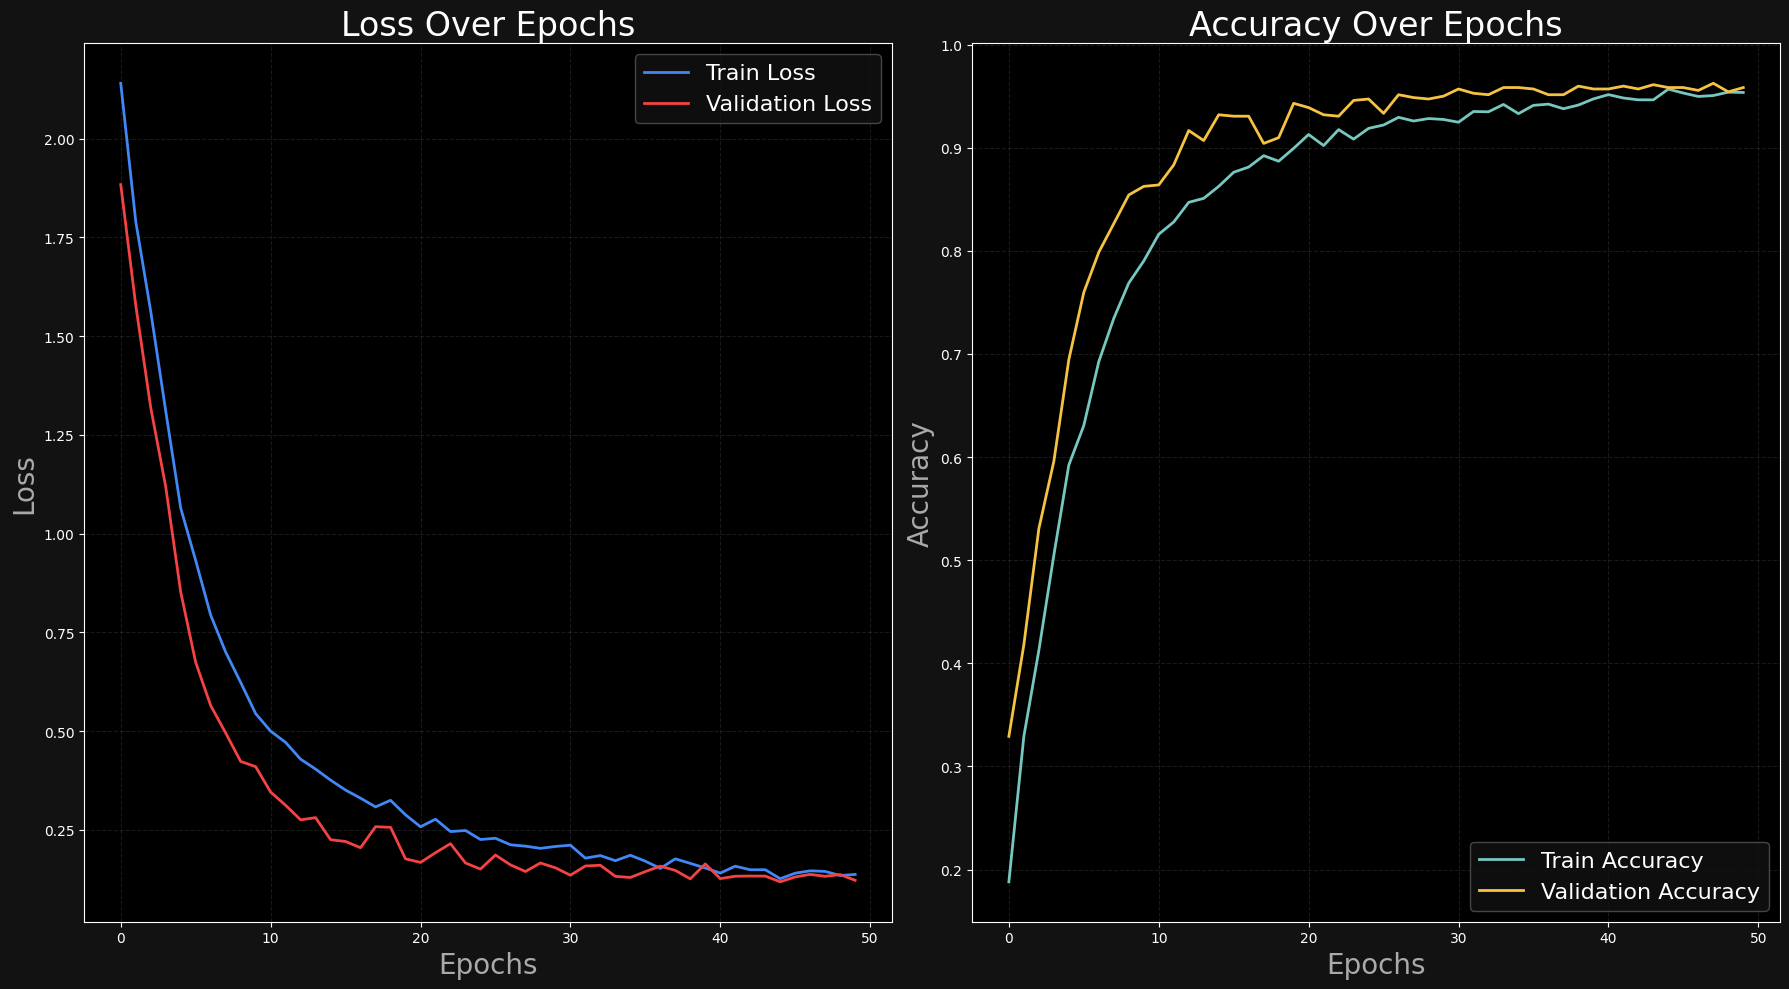

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10), facecolor='#121212')

# Loss Plot
axs[0].plot(train_losses, label="Train Loss", color="#4187f6", linewidth=2)
axs[0].plot(val_losses, label="Validation Loss", color="#f54242", linewidth=2)
axs[0].set_title("Loss Over Epochs", fontsize=24, color="#ffffff")
axs[0].set_xlabel("Epochs", fontsize=20, color="#aaaaaa")
axs[0].set_ylabel("Loss", fontsize=20, color="#aaaaaa")
axs[0].legend(facecolor="#121212", edgecolor="#555555", fontsize=16)
axs[0].grid(color="#555555", linestyle="--", alpha=0.3)

# Accuracy Plot
axs[1].plot(train_accuracies, label="Train Accuracy", color="#76c7c0", linewidth=2)
axs[1].plot(val_accuracies, label="Validation Accuracy", color="#f6c242", linewidth=2)
axs[1].set_title("Accuracy Over Epochs", fontsize=24, color="#ffffff")
axs[1].set_xlabel("Epochs", fontsize=20, color="#aaaaaa")
axs[1].set_ylabel("Accuracy", fontsize=20, color="#aaaaaa")
axs[1].legend(facecolor="#121212", edgecolor="#555555", fontsize=16)
axs[1].grid(color="#555555", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("train_loss_darkk.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())


In [50]:
torch.save(model.state_dict(), "digit_model_weights_new.pth")


In [51]:
torch.save(model, "digit_model_full_matan_new.pth")


In [52]:
# Load the best model for evaluation
model.load_state_dict(torch.load("digit_model_weights_new.pth"))

# Get predictions and true labels
test_loss, test_acc, all_labels, all_preds = evaluate(model, test_loader, return_preds=True)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9597, Test Loss: 0.1372


In [53]:

report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)], digits=4)
print(report)


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        72
           1     0.9718    0.9583    0.9650        72
           2     0.9863    1.0000    0.9931        72
           3     0.9600    1.0000    0.9796        72
           4     0.9848    0.9028    0.9420        72
           5     1.0000    1.0000    1.0000        72
           6     0.8889    0.8889    0.8889        72
           7     0.9600    1.0000    0.9796        72
           8     0.9342    0.9861    0.9595        72
           9     0.9118    0.8611    0.8857        72

    accuracy                         0.9597       720
   macro avg     0.9598    0.9597    0.9593       720
weighted avg     0.9598    0.9597    0.9593       720



In [54]:
with open("classification_report.txt", "w") as f:
    f.write(report)

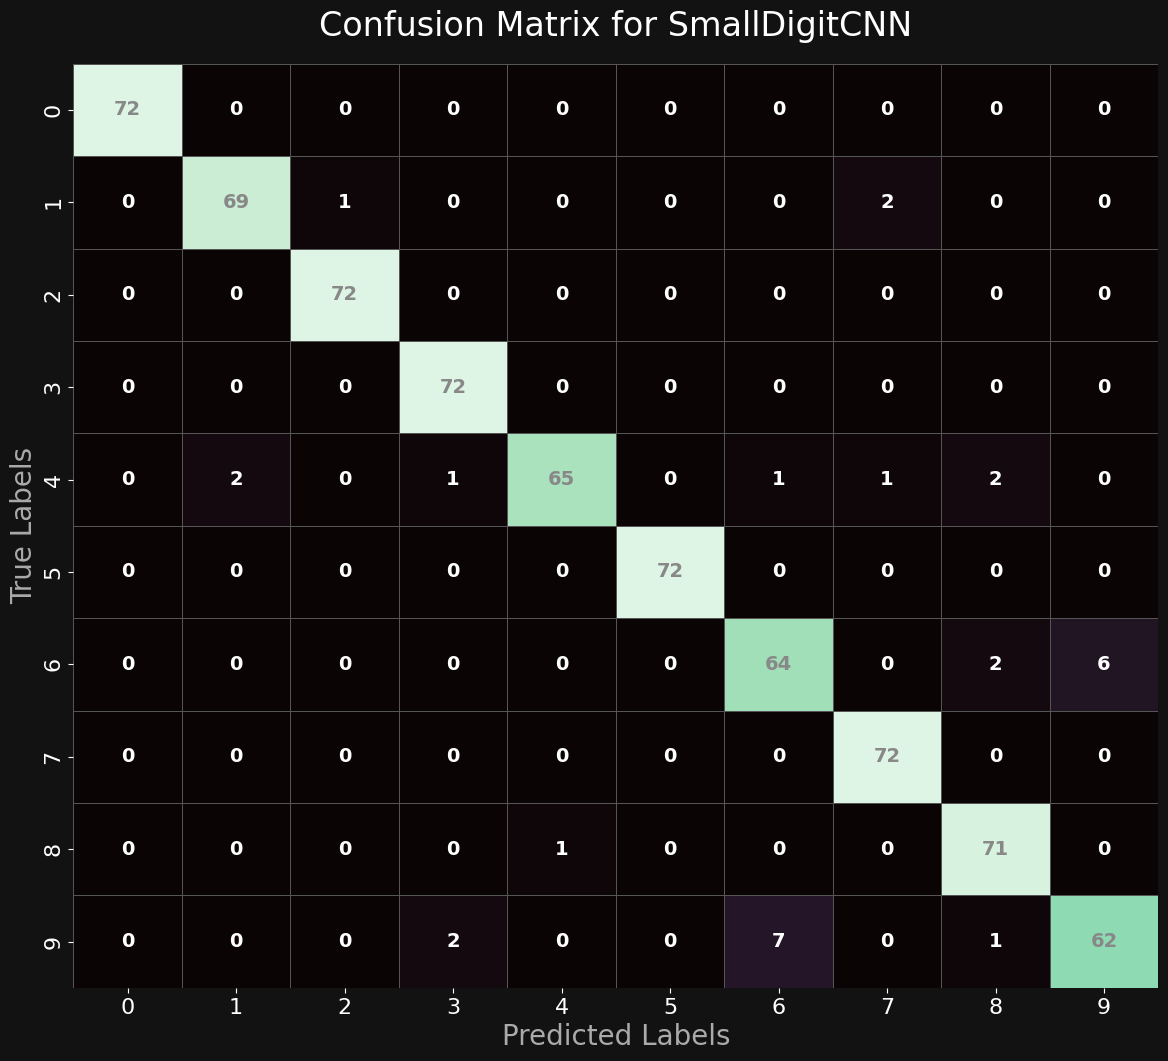

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Dark mode settings
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#121212')

# Draw the heatmap
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    cmap="mako",
    cbar=False,
    linewidths=0.5,
    linecolor="#555555",
    ax=ax
)

# Add custom diagonal text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if i == j:
            # Darker color for diagonal
            text_color = "#888888"
        else:
            # Brighter color for off-diagonal
            text_color = "#ffffff"
        ax.text(j + 0.5, i + 0.5, value, ha="center", va="center", fontsize=14, fontweight="bold", color=text_color)

# Customize axis labels and title
ax.set_xlabel("Predicted Labels", fontsize=20, color="#aaaaaa")
ax.set_ylabel("True Labels", fontsize=20, color="#aaaaaa")
ax.set_title("Confusion Matrix for SmallDigitCNN", fontsize=24, color="#ffffff", pad=20)

# Customize ticks
plt.xticks(fontsize=16, color="#ffffff")
plt.yticks(fontsize=16, color="#ffffff")

# Save the figure
plt.savefig("confusion_matrix_custom_diagonal.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

plt.show()


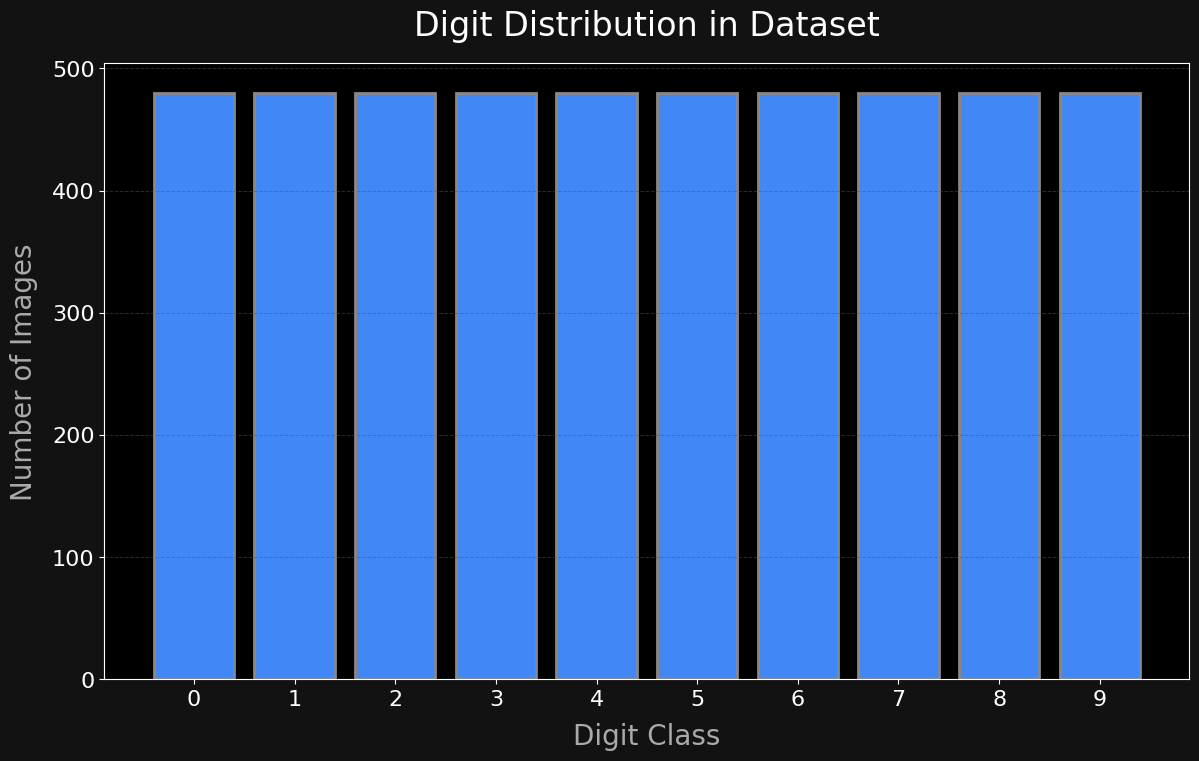

In [56]:
import os
import matplotlib.pyplot as plt

# Set the path to the dataset directory (make sure it exists in Colab)
from google.colab import drive
#drive.mount('/content/dataset/dataset_aug')

dataset_path = '/content/dataset/dataset_aug'  # Update this to your actual path

# Count the number of images in each class folder (0-9)
class_counts = {}
for class_name in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Dark mode settings
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 8), facecolor='#121212')

# Plot the bar chart
bars = ax.bar(class_counts.keys(), class_counts.values(), color='#4187f6', edgecolor='#555555')

# Add shadow effects to bars
for bar in bars:
    bar.set_linewidth(2)
    bar.set_edgecolor('#888888')

# Customize labels and title
ax.set_title('Digit Distribution in Dataset', fontsize=24, color='#ffffff', pad=20)
ax.set_xlabel('Digit Class', fontsize=20, color='#aaaaaa', labelpad=10)
ax.set_ylabel('Number of Images', fontsize=20, color='#aaaaaa', labelpad=10)

# Customize ticks
plt.xticks(fontsize=16, color='#ffffff')
plt.yticks(fontsize=16, color='#ffffff')

# Add grid for better readability
plt.grid(axis='y', color='#555555', linestyle='--', linewidth=0.7, alpha=0.5)

# Save the figure
fig.savefig("digit_distribution_dark.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

plt.show()
